Main notebook containing relevant diagnostics and important figures for the manuscript. 

It is automatically copied from \_\_main\_\_.ipynb and executed for newly trained ensembles using papermill.

This can also be updated and then triggered again by using the script `execute_ensemble_notebook.py'.

In [3]:
from pathlib import Path
import torch
from torch import nn
from torch.nn import functional as nnf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from flyvision import results_dir
from flyvision import EnsembleView

import logging

mpl.rcParams["figure.dpi"] = 300

%load_ext autoreload
%autoreload 2

In [4]:
ensemble_name = "flow/9998"  # type: str

In [5]:
validation_subdir = "validation"
loss_file_name = "EPE"

In [6]:
ensemble = EnsembleView(ensemble_name, 
                        loss_file_name=loss_file_name, 
                        validation_subdir=validation_subdir, 
                        checkpoint="best")

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-09-13 06:38:38] Failed to load results/flow/9998/040: network
[2024-09-13 06:38:41] Loaded 49 networks.


In [7]:
print(f"Description of experiment: {ensemble[0].dir.config.description}")

Description of experiment: test


# Task performance

## Training and validation losses

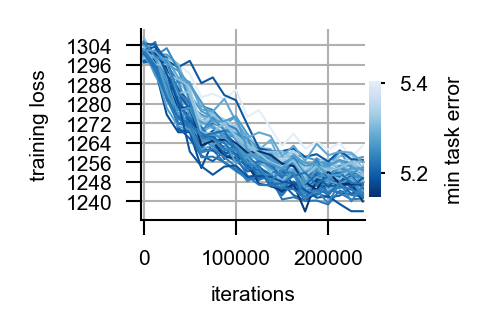

In [9]:
fig, ax = ensemble.training_loss()

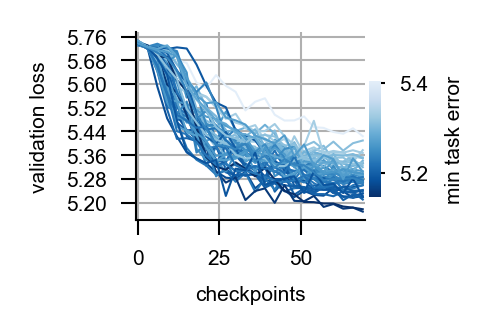

In [10]:
fig, ax = ensemble.validation_loss()

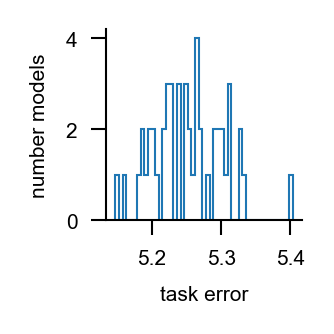

In [11]:
fig, ax = ensemble.task_error_histogram()

## Learned parameter marginals

[2024-09-12 17:35:20] flow/9998/000 differs from flow/9998/001. Diff is ['≠network_name: flow/9998/000'].


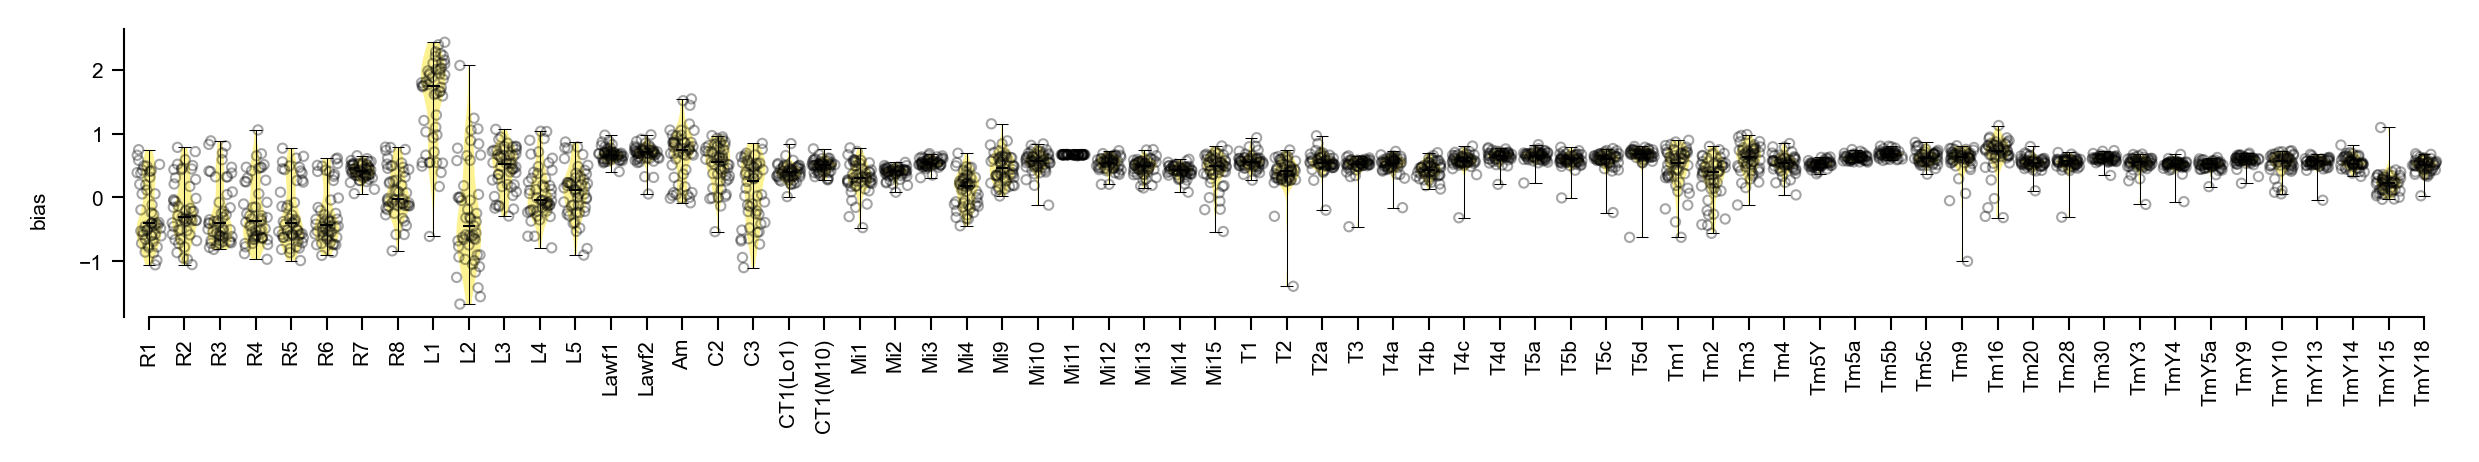

In [12]:
fig, axes = ensemble.node_parameters("bias")

[2024-09-12 17:35:29] flow/9998/000 differs from flow/9998/001. Diff is ['≠network_name: flow/9998/000'].


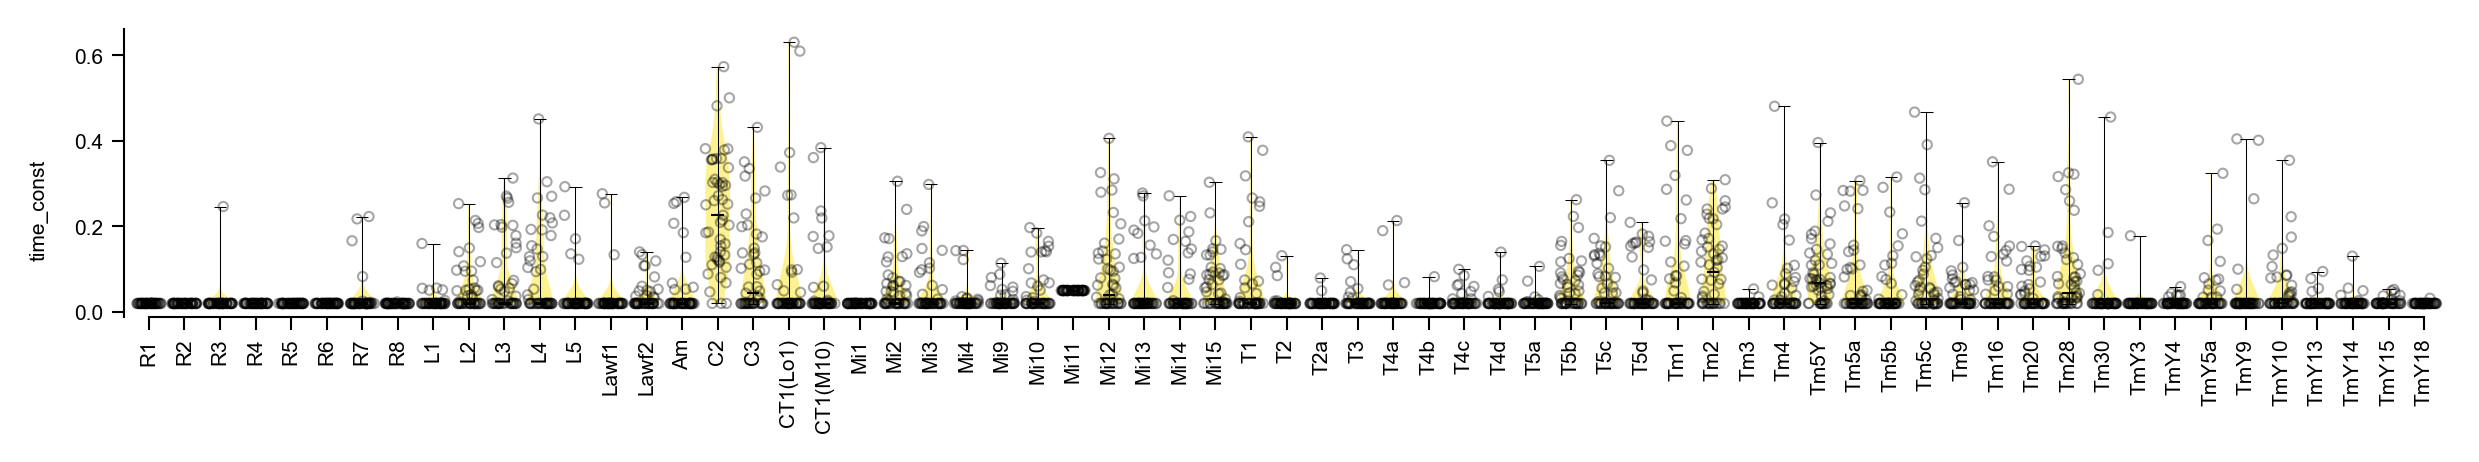

In [13]:
fig, axes = ensemble.node_parameters("time_const")

[2024-09-12 17:35:38] flow/9998/000 differs from flow/9998/001. Diff is ['≠network_name: flow/9998/000'].


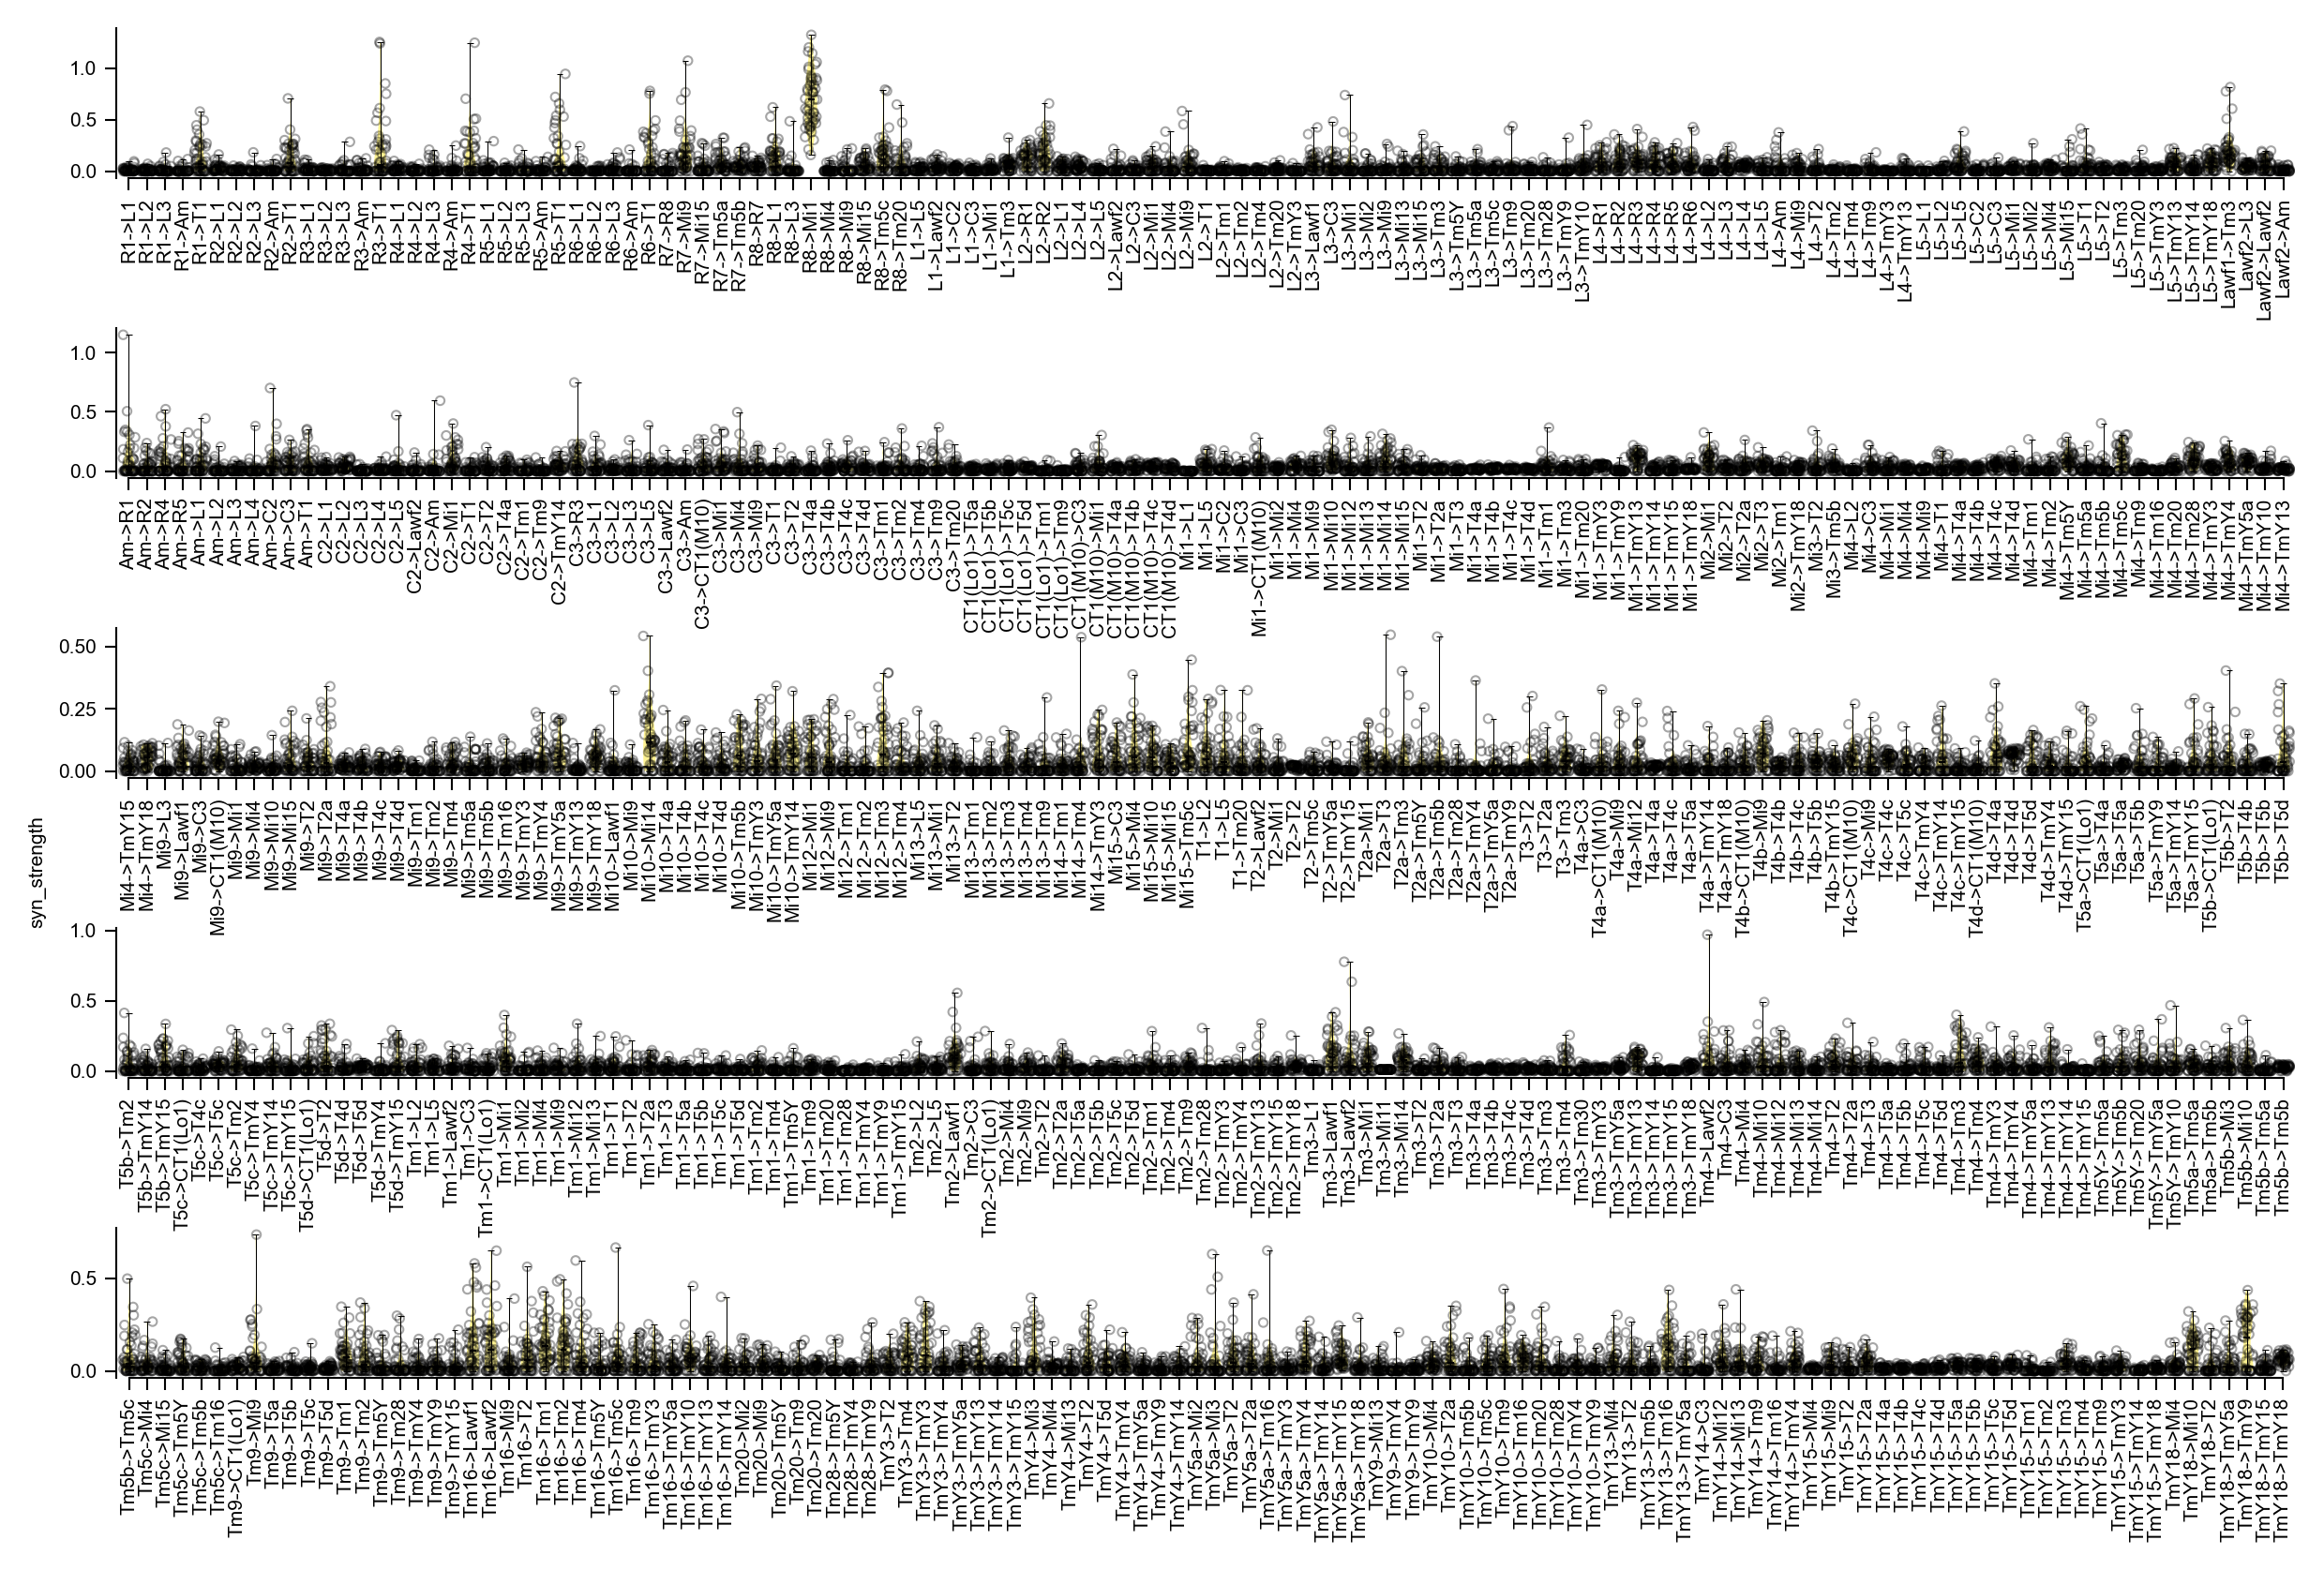

In [14]:
fig, axes = ensemble.edge_parameters("syn_strength")

## Dead or alive

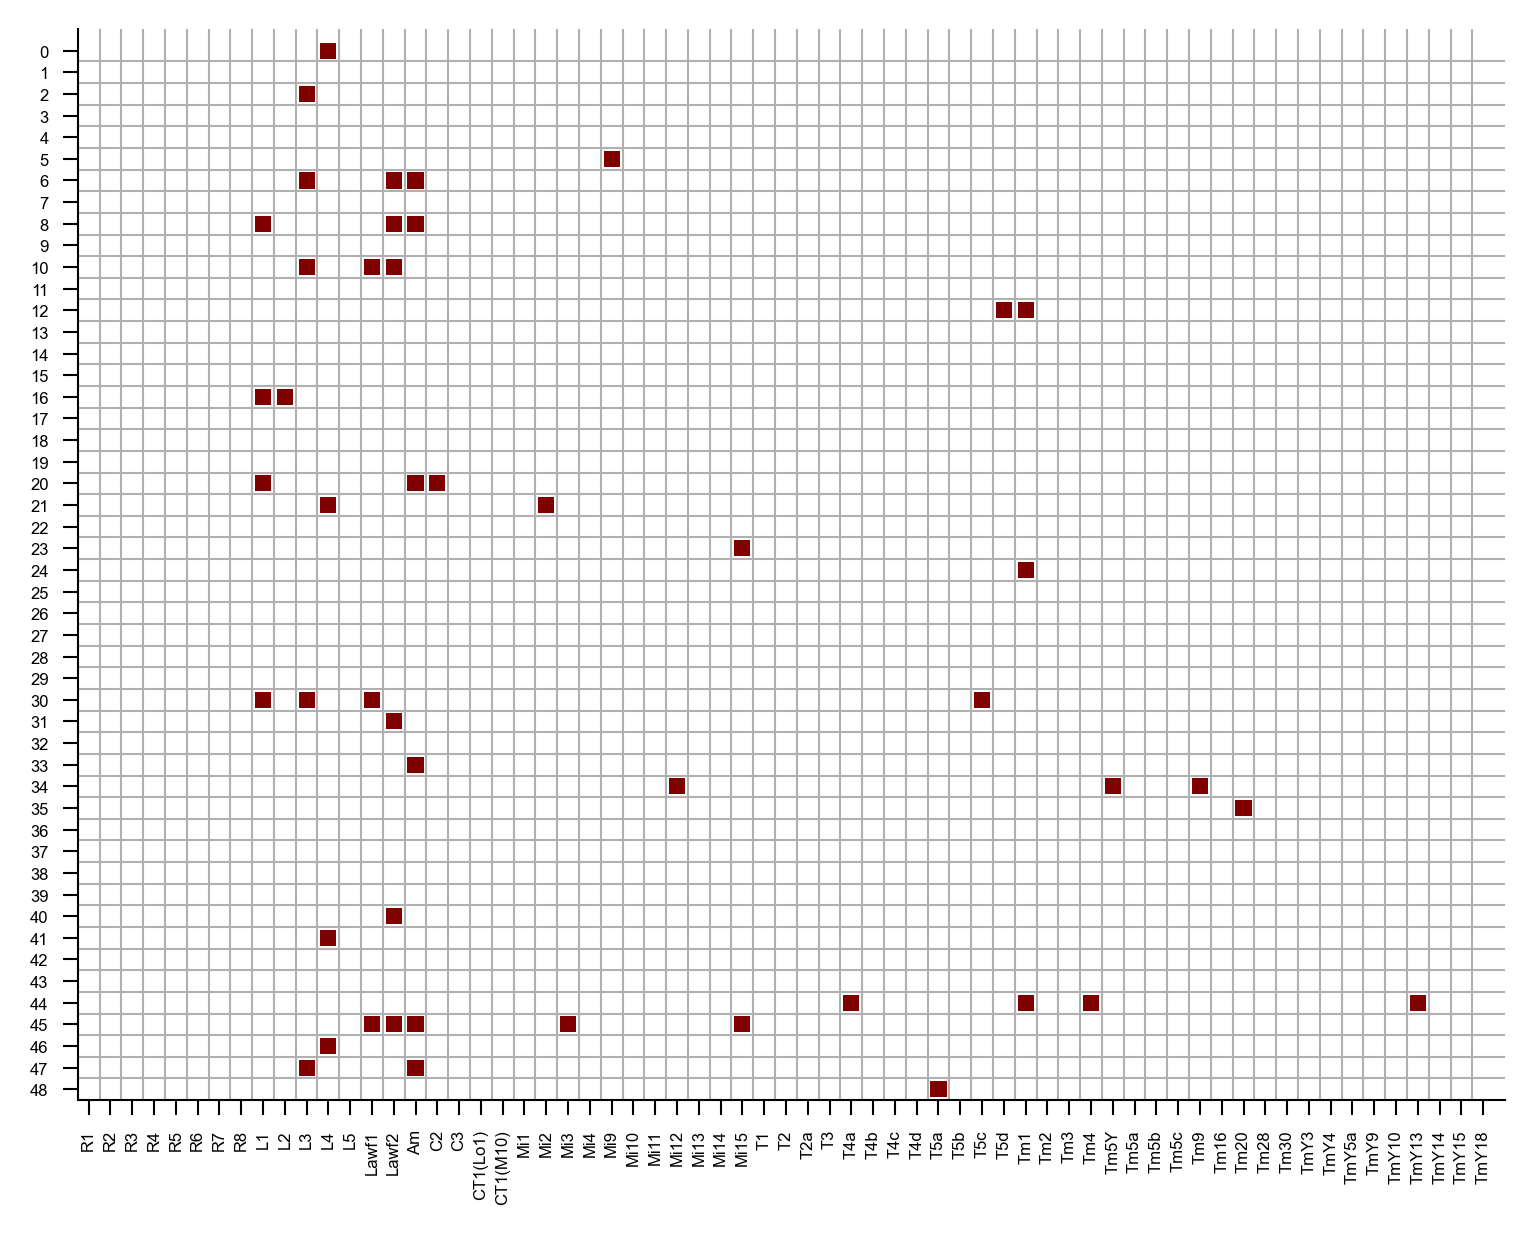

In [15]:
fig, ax, cbar, matrix = ensemble.dead_or_alive()

## Contrast selectivity and flash response indices (FRI)

#### 20% best task-performing models

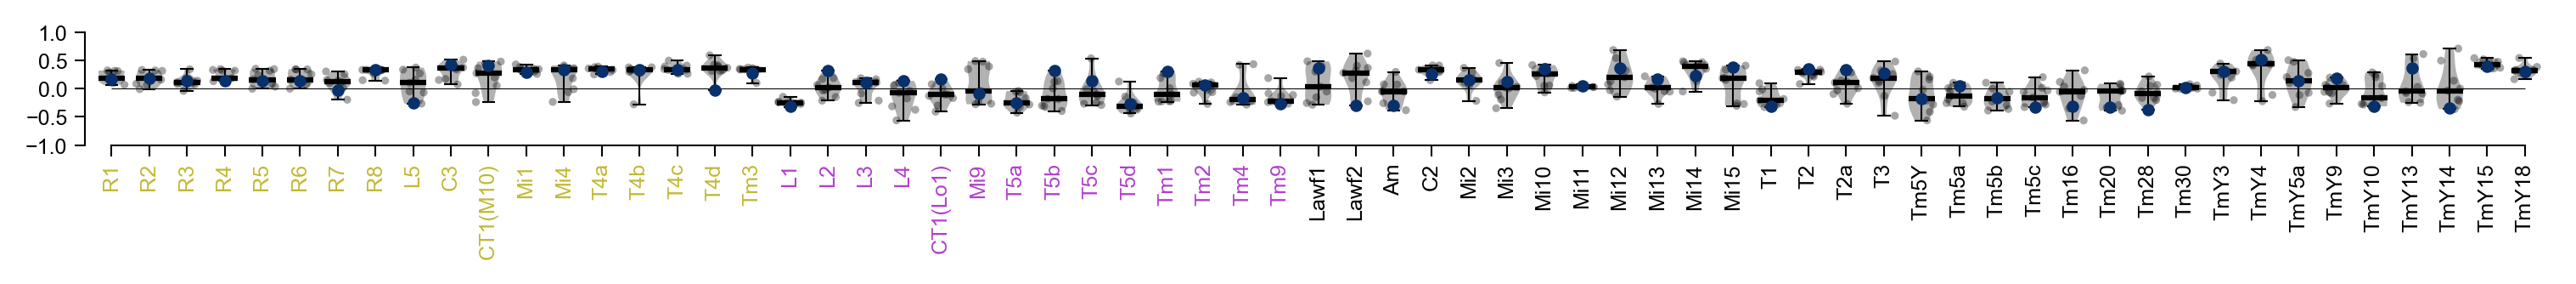

In [16]:
with ensemble.ratio(best=0.2):
    ensemble.flash_response_indices()

#### 100% models

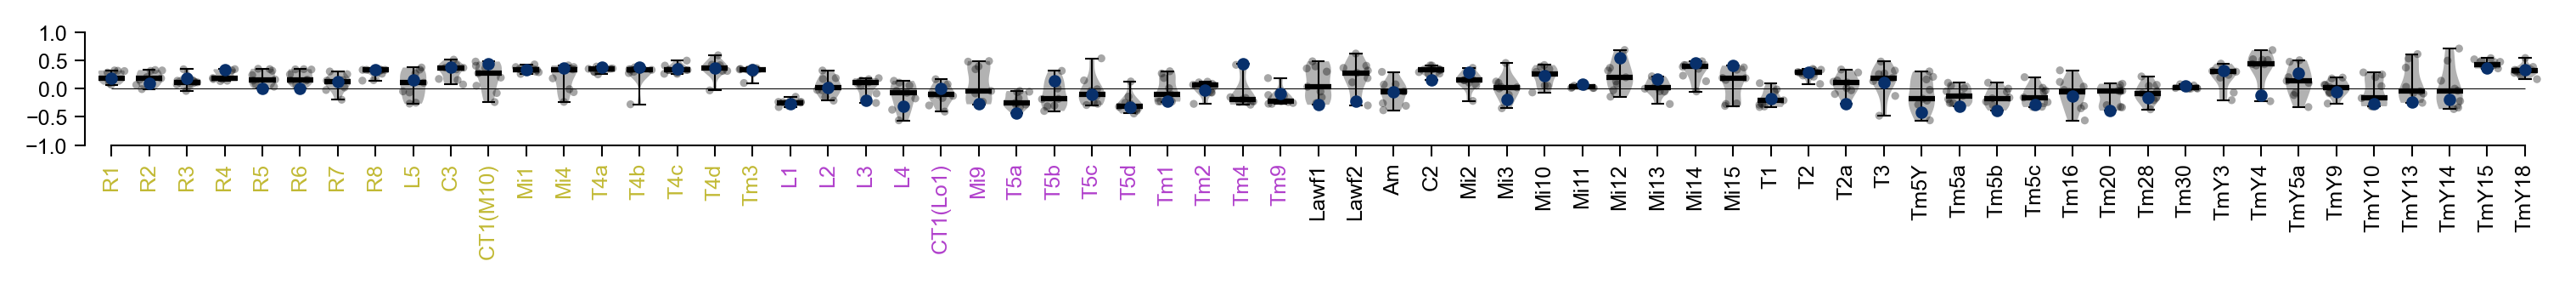

In [17]:
fig, ax = ensemble.flash_response_indices()

## Motion selectivity and direction selectivity index (DSI)

#### 20% best task-performing models

[2024-09-12 19:52:03] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-09-12 19:52:03] Recovered network state.
[2024-09-12 19:52:03] Computing 144 stimulus responses.


Batch:   0%|          | 0/144 [00:00<?, ?it/s]

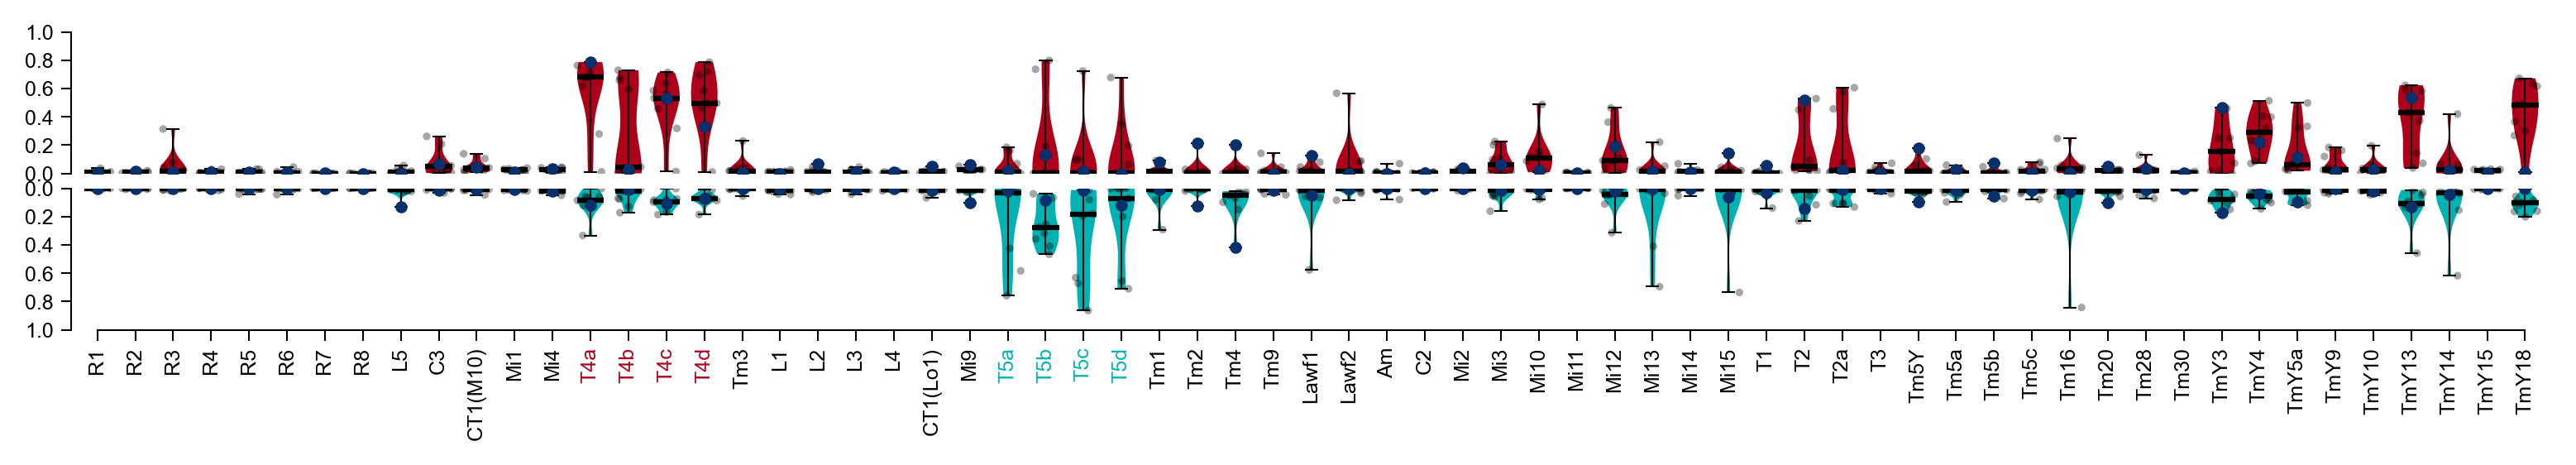

In [7]:
with ensemble.ratio(best=0.2):
    ensemble.direction_selectivity_indices()

#### 100% models

[2024-09-12 17:36:56] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-09-12 17:36:56] Recovered network state.
[2024-09-12 17:36:56] Computing 144 stimulus responses.


Batch:   0%|          | 0/144 [00:00<?, ?it/s]

(<Figure size 3000x360 with 2 Axes>, (<Axes: >, <Axes: >))

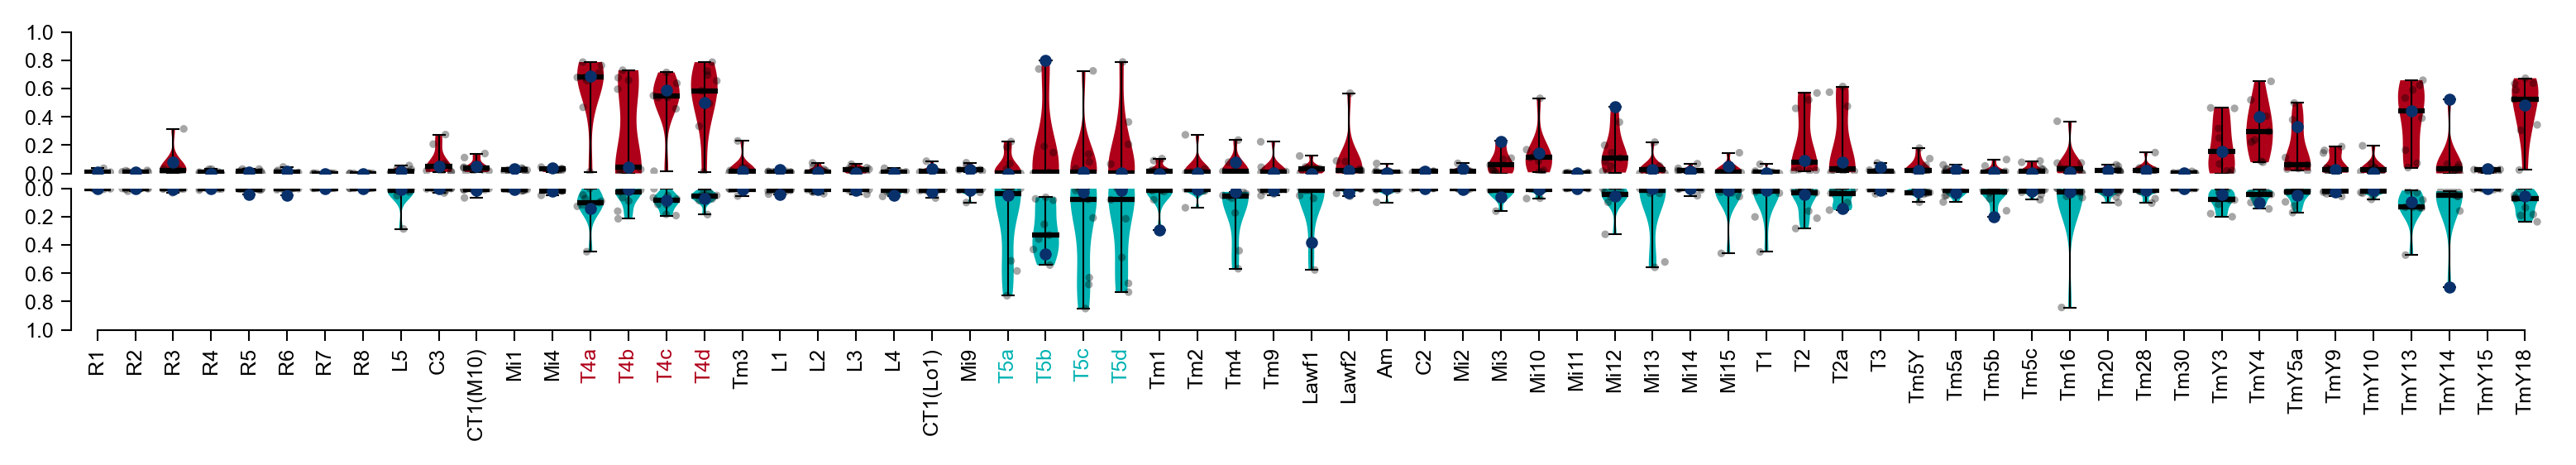

In [19]:
ensemble.direction_selectivity_indices()

## Clustering of models based on responses to naturalistic stimuli

#### T4c

[2024-09-13 06:38:43] Loaded T4c embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/9998/umap_and_clustering.


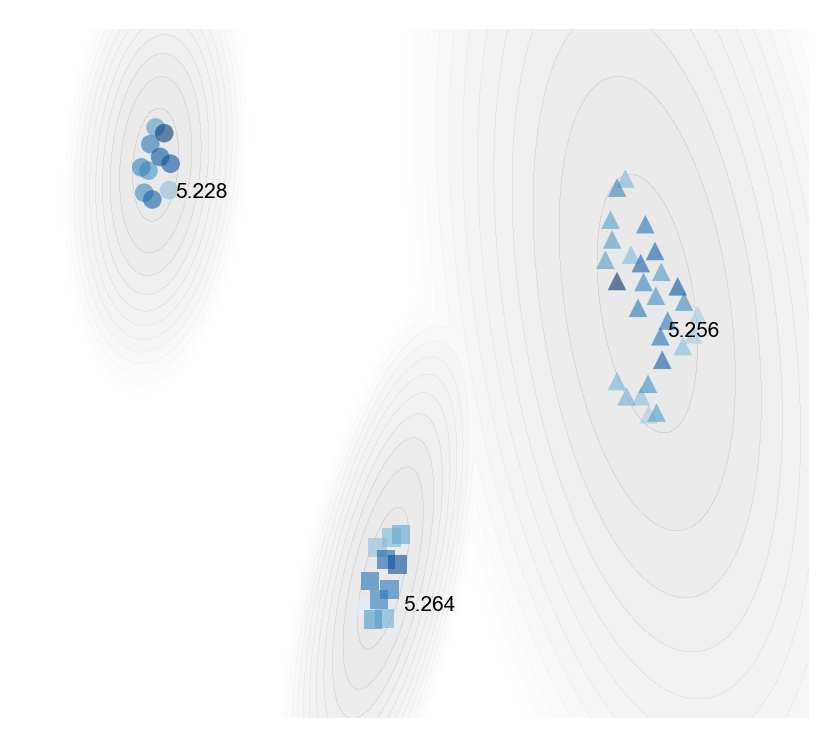

In [8]:
task_error = ensemble.task_error()
embeddingplot = ensemble.clustering("T4c").plot(task_error=task_error.values, colors=task_error.colors)

In [9]:
cluster_indices = ensemble.cluster_indices("T4c")

[2024-09-13 06:38:44] Loaded T4c embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/9998/umap_and_clustering.


In [10]:
import numpy as np
import matplotlib.pyplot as plt

from flyvision.analysis.clustering import check_markers
from flyvision.utils.activity_utils import CellTypeArray
from flyvision.plots import plt_utils 
from flyvision.plots import plots
from flyvision.datasets import MovingEdge
from flyvision.analysis.moving_bar_responses import MovingEdgeResponseView
from flyvision.utils.groundtruth_utils import tuning_curves

In [11]:
cluster_indices = ensemble.cluster_indices("T4c")

[2024-09-13 06:38:44] Loaded T4c embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/9998/umap_and_clustering.


In [12]:
dataset = MovingEdge(
                offsets=[-10, 11],
                intensities=[0, 1],
                speeds=[2.4, 4.8, 9.7, 13, 19, 25],
                height=80,
                post_pad_mode="continue",
                t_pre=1.0,
                t_post=1.0,
                dt=1 / 200,
                angles=list(np.arange(0, 360, 30)),
            )
responses = ensemble.stored_responses("movingedge_responses")

In [13]:
responses_cta = CellTypeArray(
    responses,
    connectome=ensemble.connectome,
)

In [14]:
response_view = MovingEdgeResponseView(
    arg_df=dataset.arg_df,
    responses=responses_cta,
    config=dataset.config,
    stim_sample_dim=1,
    temporal_dim=2,
)

In [15]:
cluster_colors = {}
CMAPS = ["Greens_r", "Reds_r", "Reds_r"]

for cluster_id in cluster_indices:
    cluster_colors[cluster_id] = ensemble.task_error(cmap=CMAPS[cluster_id]).colors

In [16]:
task_error_sorting = np.argsort(ensemble.task_error().values)

In [17]:
measured_tuning = np.array(tuning_curves["T4c"])
theta = np.linspace(0, 360, len(measured_tuning), endpoint=True)

In [18]:
task_error = ensemble.task_error()

In [20]:
peak_responses = response_view.peak_responses()

In [27]:
peak_responses

MovingEdgeResponseView(     angle  width  intensity    t_stim  speed
0        0     80          0  3.394397    2.4
1        0     80          0  1.697198    4.8
2        0     80          0  0.839851    9.7
3        0     80          0  0.626658   13.0
4        0     80          0  0.428766   19.0
..     ...    ...        ...       ...    ...
139    330     80          1  1.697198    4.8
140    330     80          1  0.839851    9.7
141    330     80          1  0.626658   13.0
142    330     80          1  0.428766   19.0
143    330     80          1  0.325862   25.0

[144 rows x 5 columns], {'R1': 'Array((12, 49, 1, 2, 6, 1, 65))', 'R2': 'Array((12, 49, 1, 2, 6, 1, 65))', 'R3': 'Array((12, 49, 1, 2, 6, 1, 65))', 'R4': 'Array((12, 49, 1, 2, 6, 1, 65))', 'R5': 'Array((12, 49, 1, 2, 6, 1, 65))', 'R6': 'Array((12, 49, 1, 2, 6, 1, 65))', 'R7': 'Array((12, 49, 1, 2, 6, 1, 65))', 'R8': 'Array((12, 49, 1, 2, 6, 1, 65))', 'L1': 'Array((12, 49, 1, 2, 6, 1, 65))', 'L2': 'Array((12, 49, 1, 2, 6,

(<Figure size 600x300 with 4 Axes>, <PolarAxes: >)

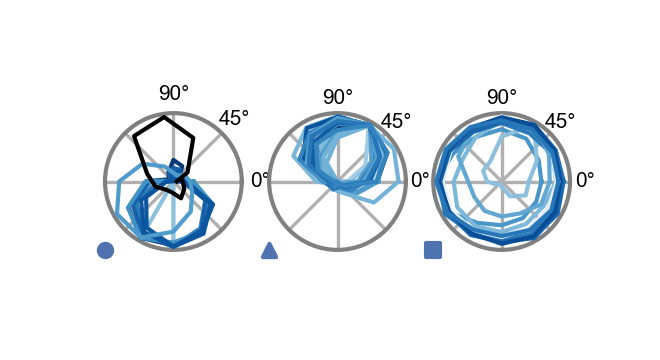

In [28]:
fig, axes = plt.subplots(1, len(cluster_indices), subplot_kw={'projection': 'polar'},
                         figsize=[2, 1])
for cluster_id, model_ids in cluster_indices.items():
    ax = axes[cluster_id]
    response_view[model_ids, :, :].plot_angular_tuning(
        cell_type="T4c",
        intensity=1,
        colors=task_error.colors[model_ids],
        fig=fig,
        ax=ax,
        zorder=task_error_sorting[model_ids][::-1],
        peak_responses = peak_responses[:, model_ids],
        average_models=False
    )


n_clusters = len(cluster_indices)

axes = np.atleast_2d(axes)
MARKERS = check_markers(n_clusters)
for column in range(axes.shape[1]):
    marker = MARKERS[column]
    plt_utils.add_cluster_marker(
        fig, axes[-1, column], marker=marker, color="#4F73AE", marker_size=10,
    )

plots.polar(
    theta,
    measured_tuning / measured_tuning.max(),
    fig=fig,
    ax=axes[0, 0],
    color="k",
    linewidth=1,
    fontsize=5,
    anglepad=-6,
)